In [6]:
using ReactiveMP, Rocket, GraphPPL, Random, LinearAlgebra, Plots, Flux, Zygote, ForwardDiff, DataFrames, DelimitedFiles

In [7]:
sensors = readdlm("sensors.txt")
sensor1, sensor2, sensor3 = sensors[1,:], sensors[2,:], sensors[3,:]
observation = readdlm("observation.txt")
position = readdlm("position.txt")
# T = size(observation)[1]
T = 15
observation_list = [observation[t,:] for t=1:T];

In [8]:
struct MyOptimizer end

In [9]:
function ReactiveMP.cvi_update!(opt::MyOptimizer, a, b)
    return vec(a)
end

In [18]:
opt = Descent(0.1)

callback_optimizer = (λ, ∇) -> begin 
    return Flux.Optimise.update!(opt, vec(λ), vec(∇))
end

#39 (generic function with 1 method)

In [38]:
A = [1.0 0.0 1.0 0.0; 0.0 1.0 0.0 1.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0]
B = [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0]
# Nonlinear function that maps states to observations
function g(z)
    pos = B*z
    o1 = sqrt(sum((pos-sensor1).^2))
    o2 = sqrt(sum((pos-sensor2).^2))
    o3 = sqrt(sum((pos-sensor3).^2))
    o = [o1,o2,o3]
end

@model function sensor_fusion(T, optimizer)
    W ~ Wishart(4, diagm(0=>ones(4)))
    R ~ Wishart(3, diagm(0=>ones(3)))

    z = randomvar(T)
    x = randomvar(T)
    y = datavar(Vector{Float64}, T)

    z[1] ~ MvNormalMeanPrecision(zeros(4), W)
    x[1] ~ g(z[1]) where {meta = CVIApproximation(2000, 100, optimizer)}
    y[1] ~ MvNormalMeanPrecision(x[1], R)

    for t in 2:T
        z[t] ~ MvNormalMeanPrecision(A * z[t-1], W)
        x[t] ~ g(z[t]) where {meta = CVIApproximation(2000, 100, optimizer)}
        y[t] ~ MvNormalMeanPrecision(x[t], R)
    end

    return z, x, y
end

constraints = @constraints begin
    q(z, x, W, R) = q(z)q(W)q(x)q(R)
end;

In [39]:
res = inference(
    model = Model(sensor_fusion, T, callback_optimizer),
    data = (y = observation_list,),
    iterations = 1,
    free_energy = false,
    returnvars = (z = KeepLast(),),
    constraints = constraints,
    initmessages = (z = MvNormalMeanPrecision(zeros(4), 0.01*diagm(0=>ones(4))),),
    initmarginals = (R = Wishart(3, diagm(0=>ones(3))), W = Wishart(4, diagm(0=>ones(4))))
)

Inference results:
-----------------------------------------
z = MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNorma...


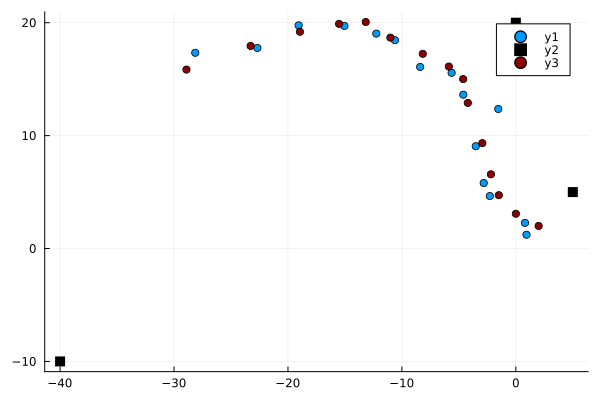

In [40]:
points = map(z -> mean(z)[1:2], res.posteriors[:z]);
x = map(z -> z[1], points);
y = map(z -> z[2], points);
plot(x, y, seriestype = :scatter)
plot!([sensor1[1],sensor2[1],sensor3[1]],[sensor1[2],sensor2[2],sensor3[2]],
    seriestype = :scatter, color=:black, markersize=5, markershape=:square)
plot!(position'[1:15, 1], position'[1:15, 2], seriestype = :scatter, color=:redsblues)